# Making progress on data exploration

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# get pandas
import pandas as pd
# we'll do some visual checks, get the necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
# to save the models
import pickle

In [17]:
# get the input df
df_raw = pd.read_csv('../data/train.csv')

In [138]:
# wrapper function to perform some simple cleanup
def clean_df(df):
    # keep only certain variable types
    df = df.select_dtypes(include=['int64','float64'])
    # drop everything with more than 10% of missing values
    df = df[df.columns[df.isnull().mean() < 0.1]]
    # looks like Garage built goes with Year built, replace NA using that
    df.loc[df['GarageYrBlt'].isnull(),'GarageYrBlt'] = df['YearBuilt']
    # put zero for MasVnrArea
    df.loc[df['MasVnrArea'].isnull(),'MasVnrArea'] = 0.0
    # drop id
    df = df.drop(['Id'], axis=1)    
    # remove outliers
    df = df[df['GrLivArea'] < 4676] 
    return df

In [139]:
df = clean_df(df_raw)

In [43]:
# check again missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# show columns with most missing entries
missing_data.head(5)

,Total,Percent
SalePrice,0,0.0
YrSold,0,0.0
BsmtFullBath,0,0.0
GrLivArea,0,0.0
LowQualFinSF,0,0.0


In [44]:
df.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

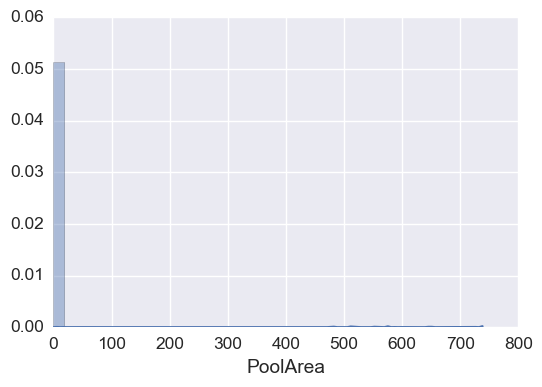

In [115]:
# check ratio between MasVnrArea and other stuff
sns.distplot(df['PoolArea']);

In [97]:
# Input a pandas series 
def ent(data, removeZeros = False):
    if removeZeros:
        data = data[data > 0]
    p_data= data.value_counts()/len(data) # calculates the probabilities
    entropy=sc.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

In [101]:
import scipy as sc
print(ent(df['ScreenPorch'],True))

4.13657936666


In [116]:
new_dict = {}
for col in df.columns:
    new_dict[col] = ent(df[col],False)

In [117]:
for k,v in sorted(new_dict.items(), key=lambda p:p[1], reverse=False):
    print(k,v)

PoolArea 0.0397168043136
3SsnPorch 0.130969541835
LowQualFinSF 0.144195862942
KitchenAbvGr 0.198034817833
BsmtHalfBath 0.222720679495
MiscVal 0.246217162202
ScreenPorch 0.606088785955
HalfBath 0.70090990075
BsmtFullBath 0.731342645964
FullBath 0.815217521784
BsmtFinSF2 0.91613707451
Fireplaces 0.934093343099
EnclosedPorch 1.05524992386
GarageCars 1.10914650097
BedroomAbvGr 1.18377260363
OverallCond 1.3349118855
YrSold 1.5860438538
OverallQual 1.72387129177
TotRmsAbvGrd 1.86469186536
MSSubClass 2.02494552759
MoSold 2.33631705816
MasVnrArea 2.93727784859
WoodDeckSF 3.07734199791
2ndFlrSF 3.21154911982
OpenPorchSF 3.34698552761
YearRemodAdd 3.70139522014
GarageYrBlt 4.28037190288
YearBuilt 4.34393606908
BsmtFinSF1 4.91778167755
GarageArea 5.37280134972
SalePrice 6.13283697977
TotalBsmtSF 6.22437770826
BsmtUnfSF 6.24853799108
1stFlrSF 6.3762120614
GrLivArea 6.53330737225
LotArea 6.72172999342


In [148]:
# now we will look at the variable ranking with a different approach, GBT
from sklearn import ensemble
# prep scikit
input_features = list(df.columns)
input_features.remove('SalePrice')
X = df[input_features].values
y = np.log(df['SalePrice']+1).values

In [149]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [150]:
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

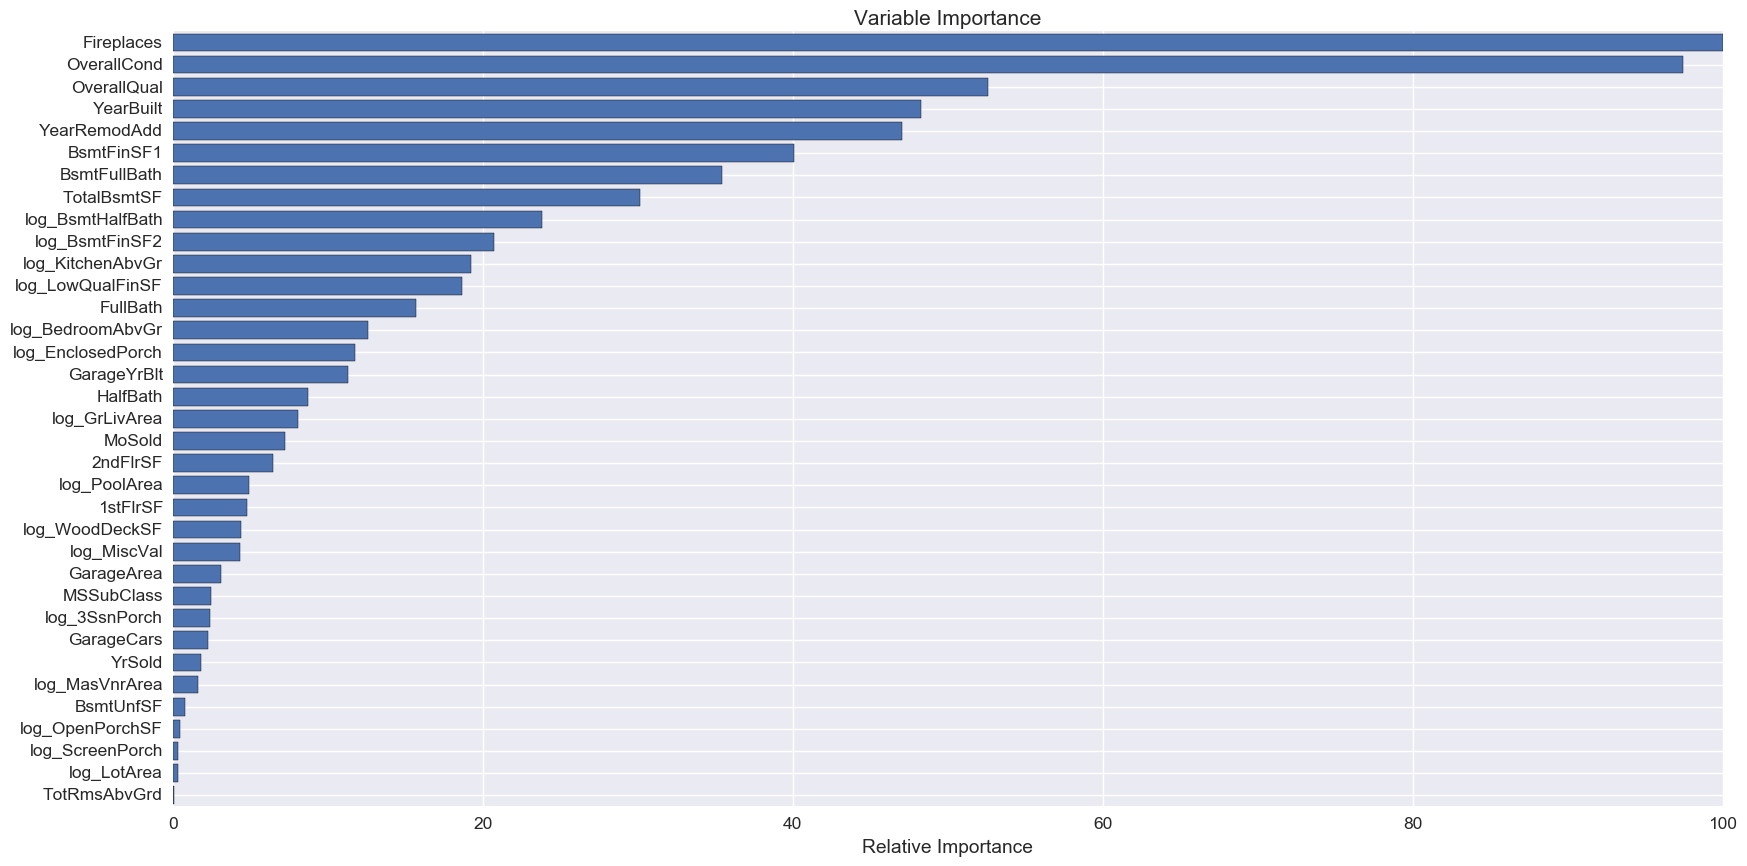

In [160]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, [input_features[i] for i in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [161]:
# to have an idea of the score
from sklearn.model_selection import cross_val_score
# check model performance
scores = cross_val_score(clf, X, y, cv=3, scoring='neg_mean_squared_error')
# transform scores into the root mean square
scores = np.sqrt(-scores)
print("Mean Squared Error (on Log): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Mean Squared Error (on Log): 0.13 (+/- 0.01)


In [162]:
# retry with logged columns also in input
# allright get into the log col those with kurt > 2
log_col = []
for col in input_features:
    if abs(df[col].kurt()) > 2:
        log_col += [col]
print(log_col)

['log_LotArea', 'log_BsmtFinSF2', 'log_LowQualFinSF', 'log_BsmtHalfBath', 'log_BedroomAbvGr', 'log_KitchenAbvGr', 'log_EnclosedPorch', 'log_3SsnPorch', 'log_ScreenPorch', 'log_PoolArea', 'log_MiscVal']


In [156]:
# get the new transformed columns and remove the old ones
for col in log_col:
    df['log_' + col] = np.log(df[col] + 1)
    df = df.drop([col], axis=1)
print(df.columns)

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'MoSold', 'YrSold',
       'SalePrice', 'log_LotArea', 'log_MasVnrArea', 'log_BsmtFinSF2',
       'log_LowQualFinSF', 'log_GrLivArea', 'log_BsmtHalfBath',
       'log_BedroomAbvGr', 'log_KitchenAbvGr', 'log_WoodDeckSF',
       'log_OpenPorchSF', 'log_EnclosedPorch', 'log_3SsnPorch',
       'log_ScreenPorch', 'log_PoolArea', 'log_MiscVal'],
      dtype='object')


In [157]:
# redo the test
input_features = list(df.columns)
input_features.remove('SalePrice')
X = df[input_features].values

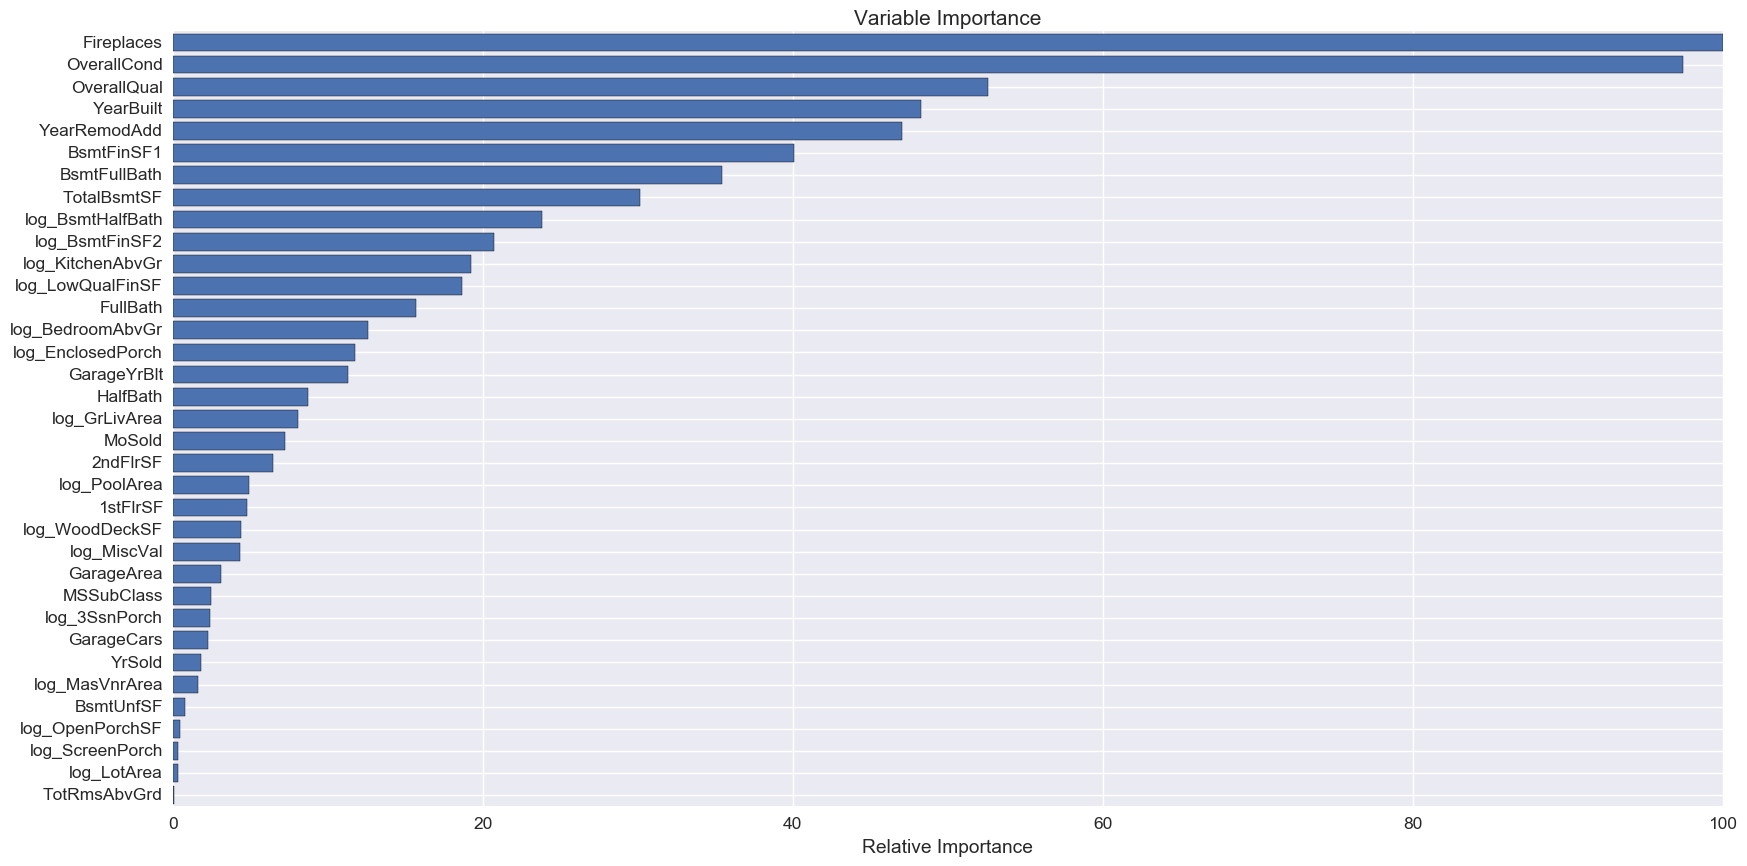

In [158]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, [input_features[i] for i in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [159]:
# check model performance
scores = cross_val_score(clf, X, y, cv=3, scoring='neg_mean_squared_error')
# transform scores into the root mean square
scores = np.sqrt(-scores)
print("Mean Squared Error (on Log): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Mean Squared Error (on Log): 0.13 (+/- 0.01)
